In [1]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import ast

def load(file):
    df = pd.read_csv(file)
    
    # convert the column values from literal string to dictionary
    df['ltiFeatures'] = df['ltiFeatures'].apply(ast.literal_eval)
    df['stiFeatures'] = df['stiFeatures'].apply(ast.literal_eval)

    return df

# load all the data
training = load("training.csv")
validation = load("validation.csv")
interest_topics = pd.read_csv("interest_topics.csv")

data_train = pd.DataFrame(list(training['ltiFeatures']))
data_train.head()
y_train = training['inAudience']

data_train = np.nan_to_num(data_train)

y_train = np.nan_to_num(y_train)

y_train = y_train.astype(int)

Using TensorFlow backend.


In [2]:
for i in range(0,96406):
    if y_train[i] == 0:
        y_train[i] = -1

In [3]:
 #used to help randomly select the data points
data_split = 0.2
seed = 1234

In [4]:
# take data corresponding to false
x_train = data_train[1465:,:]
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
#df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
#df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))
#df_test_0_x_rescaled = scaler.transform(df_test_0_x)
#df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

In [6]:
pca = PCA(0.99)
pca.fit(x_train_scaled)
x_pca_train = pca.transform(x_train_scaled)

In [50]:
batch_size = 128
input_dim = x_pca_train.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(374, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(94, activation="relu")(encoder)
encoder = Dense(24, activation="relu")(encoder)
encoder = Dense(6, activation="relu")(encoder)
decoder = Dense(6, activation="relu")(encoder)
decoder = Dense(24, activation="relu")(decoder)
decoder = Dense(94, activation="relu")(decoder)
decoder = Dense(374, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1413)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 374)               528836    
_________________________________________________________________
dense_20 (Dense)             (None, 94)                35250     
_________________________________________________________________
dense_21 (Dense)             (None, 24)                2280      
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 150       
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_24 (Dense)             (None, 24)                168 

In [10]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')


In [69]:
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=1)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(x_pca_train, x_pca_train,
                    epochs = 50,
                    batch_size=100,
                    shuffle=True,
                    validation_split = 0.2,
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 75952 samples, validate on 18989 samples
Epoch 1/50
75952/75952 [==============================] - 28s 367us/step - loss: 3.4761 - accuracy: 0.0167 - val_loss: 1.2889 - val_accuracy: 0.0086

Epoch 00001: val_loss improved from inf to 1.28889, saving model to autoencoder_classifier.h5
Epoch 2/50
75952/75952 [==============================] - 27s 360us/step - loss: 1.0571 - accuracy: 0.0167 - val_loss: 1.2650 - val_accuracy: 0.0120

Epoch 00002: val_loss improved from 1.28889 to 1.26498, saving model to autoencoder_classifier.h5
Epoch 3/50
75952/75952 [==============================] - 27s 359us/step - loss: 1.0620 - accuracy: 0.0191 - val_loss: 1.2642 - val_accuracy: 0.0164

Epoch 00003: val_loss improved from 1.26498 to 1.26422, saving model to autoencoder_classifier.h5
Epoch 4/50
75952/75952 [==============================] - 23s 309us/step - loss: 1.0541 - accuracy: 0.0222 - val_loss: 1.2535 - val_accuracy: 0.0149

Epoch 00004: val_loss improved from 1.26422 to 1.25346, savi

75952/75952 [==============================] - 25s 328us/step - loss: 1.0153 - accuracy: 0.0021 - val_loss: 1.2473 - val_accuracy: 0.0035

Epoch 00039: val_loss did not improve from 1.22911
Epoch 40/50
75952/75952 [==============================] - 24s 319us/step - loss: 1.0150 - accuracy: 0.0043 - val_loss: 1.2468 - val_accuracy: 0.0032

Epoch 00040: val_loss did not improve from 1.22911
Epoch 41/50
75952/75952 [==============================] - 25s 334us/step - loss: 1.0153 - accuracy: 0.0019 - val_loss: 1.2466 - val_accuracy: 0.0026

Epoch 00041: val_loss did not improve from 1.22911
Epoch 42/50
75952/75952 [==============================] - 28s 367us/step - loss: 1.0143 - accuracy: 0.0018 - val_loss: 1.2479 - val_accuracy: 0.0035

Epoch 00042: val_loss did not improve from 1.22911
Epoch 43/50
75952/75952 [==============================] - 22s 288us/step - loss: 1.0138 - accuracy: 0.0016 - val_loss: 1.2470 - val_accuracy: 0.0018

Epoch 00043: val_loss did not improve from 1.22911
Ep

In [11]:
autoencoder = load_model('best_encoder_normalized/autoencoder_classifier.h5')


In [12]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [14]:
data_train_scaled = scaler.transform(data_train)
data_pca_train = pca.transform(data_train_scaled)
x_predictions = autoencoder.predict(data_pca_train)

In [15]:
mse = np.mean(np.power(data_pca_train - x_predictions, 2), axis=1)
print(np.shape(mse))

(96406,)


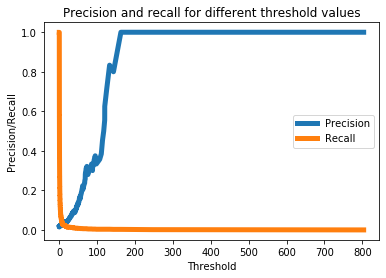

In [16]:
error = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error.True_class, error.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

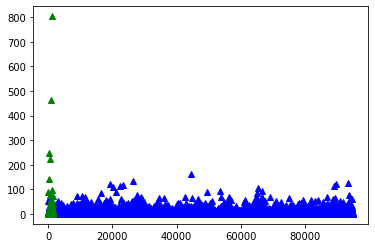

In [17]:
plt.plot(range(0,94941),mse[1465:],'b^')
plt.plot(range(0,1464),mse[0:1464],'g^')

In [20]:
data_test = pd.DataFrame(list(validation['ltiFeatures'])).drop(['1670'],axis = 1)
data_test.head()
y_test = validation['inAudience']


data_test = np.nan_to_num(data_test)

y_test = np.nan_to_num(y_test)

y_test = y_test.astype(int)

In [21]:
data_test_scaled = scaler.transform(data_test)
x_pca_test = pca.transform(data_test_scaled)

In [22]:
x__test_predictions = autoencoder.predict(x_pca_test)

In [23]:
mse_test = np.mean(np.power(x_pca_test - x__test_predictions, 2), axis=1)
print(mse_test)

[ 3.75254379  4.88103091 13.85400582 ... 23.70549052  6.82115283
  1.45873539]


In [27]:
y_test_labels = np.zeros((80008,1))
for i in range(0,80008):
    if mse_test[i] >= 200:#0.0005:
        y_test_labels[i] = 1
        

In [25]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [28]:
print(perf_measure(y_test,y_test_labels))

(14, 1766, 77622, 606)


In [102]:
np.sum(np.abs(y_test_labels-1))

79517.0

In [103]:
np.sum(np.abs(y_test-1))

79388

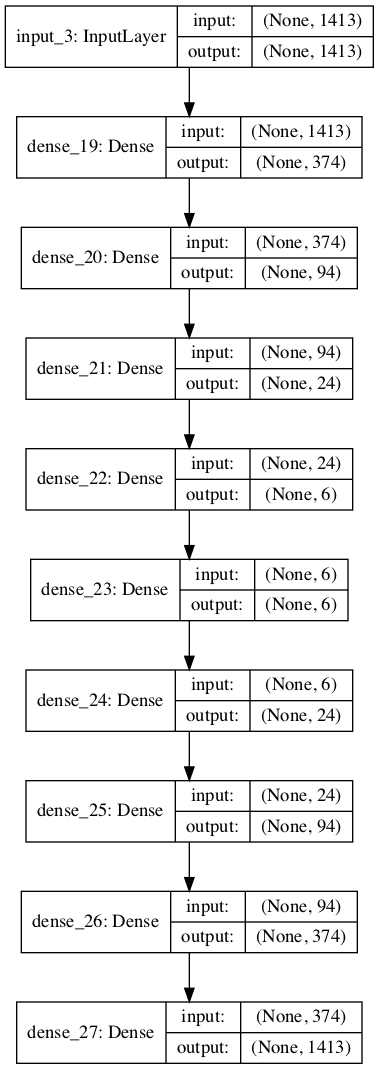

In [57]:
import keras
keras.utils.plot_model(autoencoder, to_file='test_keras_plot_model.png', show_shapes=True)
IPython.display.Image('test_keras_plot_model.png')